# Package Installation

All the necessary packages required for the data extraction, manipulation and training with and without Data Augmentation. This section is prepared to be executed within a Google Colab notebook.

In [1]:
%pip install tensorflow keras matplotlib gdown

# Library Imports

  All the necessary libraries needeed and the verification of the executing enviroment

In [2]:
import os
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import tensorflow as tf

In [3]:
# Making sure the GPU is active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('No GPU found. Make sure is correctly configured.')
print('A GPU was found in: {}'.format(device_name))

A GPU was found in: /device:GPU:0


# Dataset Download

In order to make this notebook more portable, This code snippet allows you to download and decompress the dataset containing the images directly from the source.

## Dataset: COVID-19 Radiography Database

The first dataset being used is the **COVID-19 Radiography Database**. As specified in the description: "a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal, and other lung infection dataset is released in stages." for more information check the [official site](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

In [4]:
# Importing the file  kaggle.json to download the datase
from google.colab import files
files.upload()  # Selecting kaggle.json

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading & decompressing COVID-19 dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip -d /content

# Reorganizing two folders
import os, shutil
os.makedirs('/content/covid_binary_dataset/COVID', exist_ok=True)
os.makedirs('/content/covid_binary_dataset/Normal', exist_ok=True)

for cls in ['COVID', 'Normal']:
    src_dir = f'/content/COVID-19_Radiography_Dataset/{cls}/images'
    dst_dir = f'/content/covid_binary_dataset/{cls}'
    for file in os.listdir(src_dir):
        if file.endswith('.png'):
            shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 775M/778M [00:00<00:00, 1.28GB/s]
100% 778M/778M [00:00<00:00, 1.31GB/s]


## Dataset: CUB-200-2011

The dataset being used is the **CUB-200-2011**. As specified in the description: "CUB-200-2011 is an extended version of CUB-200, a challenging dataset of 200 bird species. The extended version roughly doubles the number of images per category and adds new part localization annotations" for more information check the [official site](https://authors.library.caltech.edu/records/cvm3y-5hh21).

In [5]:
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

# Extract the images for the .tgz
!tar -xvzf "/content/drive/MyDrive/CUB_200_2011.tgz" -C "/content/"

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

# General Configuration

General configuration for the neural network images input size and the batch size will be used

In [6]:
image_size = (224, 224)
batch_size = 32
input_shape = (224, 224, 3)

### Model Generator Functions

In [7]:
def prepare_generators(data_dir, augment=False, class_mode='binary'):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='validation',
        shuffle=False
    )

    return train_gen, val_gen

In [8]:
def create_model(model_name='vgg', num_classes=1, fine_tune=False):
    base_model_class = VGG16 if model_name == 'vgg' else ResNet50
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    lr = 1e-3 if not fine_tune else 1e-5

    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    out = Dense(num_classes, activation=activation)(x)

    loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])
    return model

### Metrics Visualization Function

In [9]:
def plot_metrics(history, title_prefix=''):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Model Evaluation Function

In [ ]:
def evaluate_model(model, val_gen, class_names, title_prefix=''):
    val_gen.reset()
    y_pred = model.predict(val_gen)

    if y_pred.shape[1] == 1:
        y_pred_labels = (y_pred > 0.5).astype(int)
    else:
        y_pred_labels = np.argmax(y_pred, axis=1)

    y_true = val_gen.classes

    print(classification_report(y_true, y_pred_labels, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve (binary only)
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{title_prefix} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

# Experimental Execution

In [ ]:
def save_results(model, history, title_prefix='', y_true=None, y_pred_labels=None, y_pred_proba=None, class_names=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    os.makedirs('resultados_modelos', exist_ok=True)

    # Save model
    model_path = f'resultados_modelos/{title_prefix}_model.keras'
    model.save(model_path)

    # Save metrics
    log_path = f'resultados_modelos/{title_prefix}_history.txt'
    with open(log_path, 'w') as f:
        for key in history.history:
            f.write(f"{key}: {history.history[key]}\n")

    # Save accuracy and loss plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'resultados_modelos/{title_prefix}_metrics.png')
    plt.close()

    # Save confusion matrix
    if y_true is not None and y_pred_labels is not None:
        cm = confusion_matrix(y_true, y_pred_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{title_prefix} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'resultados_modelos/{title_prefix}_confusion_matrix.png')
        plt.close()

    # Save ROC Curve (binary only)
    if y_true is not None and y_pred_proba is not None and len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{title_prefix} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig(f'resultados_modelos/{title_prefix}_roc_curve.png')
        plt.close()

    print(f"Resultados guardados para: {title_prefix}")


Dataset: CUB, Modelo: VGG, Augmentation: False
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0094 - loss: 5.3508

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 187ms/step - accuracy: 0.0094 - loss: 5.3503 - val_accuracy: 0.0495 - val_loss: 4.9756 - learning_rate: 0.0010
Epoch 2/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0478 - loss: 4.7039 - val_accuracy: 0.0986 - val_loss: 4.2290 - learning_rate: 0.0010
Epoch 3/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.0850 - loss: 4.2095 - val_accuracy: 0.1369 - val_loss: 3.8417 - learning_rate: 0.0010
Epoch 4/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.1223 - loss: 3.9248 - val_accuracy: 0.1675 - val_loss: 3.5843 - learning_rate: 0.0010
Epoch 5/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.1570 - loss: 3.7061 - val_accuracy: 0.1946 - val_loss: 3.4222 - learning_rate: 0.0010
Epoch 6/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.1804 - loss: 3.5156 - val_accuracy: 0.2088 - val_loss: 3.3122 - learning_rate: 0.0010
Epoch 7/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.1962 - loss:

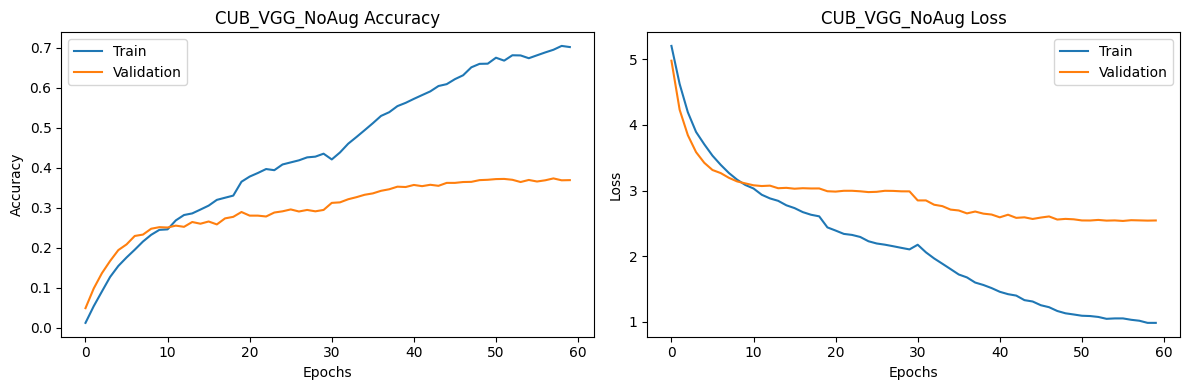

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.54      0.58      0.56        12
              002.Laysan_Albatross       0.33      0.25      0.29        12
               003.Sooty_Albatross       0.26      0.45      0.33        11
             004.Groove_billed_Ani       0.25      0.25      0.25        12
                005.Crested_Auklet       0.75      0.75      0.75         8
                  006.Least_Auklet       0.56      0.62      0.59         8
               007.Parakeet_Auklet       0.70      0.70      0.70        10
             008.Rhinoceros_Auklet       0.36      0.44      0.40         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.50      0.50      0.50        12
               011.Rusty_Blackbird       0.12      0.08      0.10        12
      

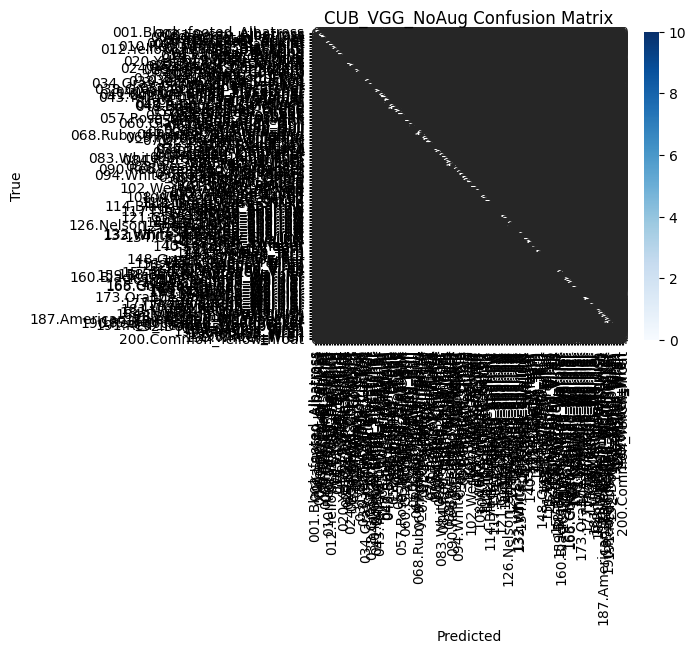

Resultados guardados para: CUB_VGG_NoAug

Dataset: CUB, Modelo: VGG, Augmentation: True
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.0080 - loss: 5.3896

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 148s 487ms/step - accuracy: 0.0080 - loss: 5.3891 - val_accuracy: 0.0443 - val_loss: 5.0349 - learning_rate: 0.0010
Epoch 2/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 473ms/step - accuracy: 0.0386 - loss: 4.7901 - val_accuracy: 0.0796 - val_loss: 4.3736 - learning_rate: 0.0010
Epoch 3/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 473ms/step - accuracy: 0.0689 - loss: 4.3769 - val_accuracy: 0.1214 - val_loss: 3.9684 - learning_rate: 0.0010
Epoch 4/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 472ms/step - accuracy: 0.0970 - loss: 4.1212 - val_accuracy: 0.1502 - val_loss: 3.7431 - learning_rate: 0.0010
Epoch 5/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - accuracy: 0.1282 - loss: 3.8909 - val_accuracy: 0.1786 - val_loss: 3.5725 - learning_rate: 0.0010
Epoch 6/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 139s 470ms/step - accuracy: 0.1477 - loss: 3.7246 - val_accuracy: 0.1911 - val_loss: 3.4731 - learning_rate: 0.0010
Epoch 7/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - accuracy: 0.1676 

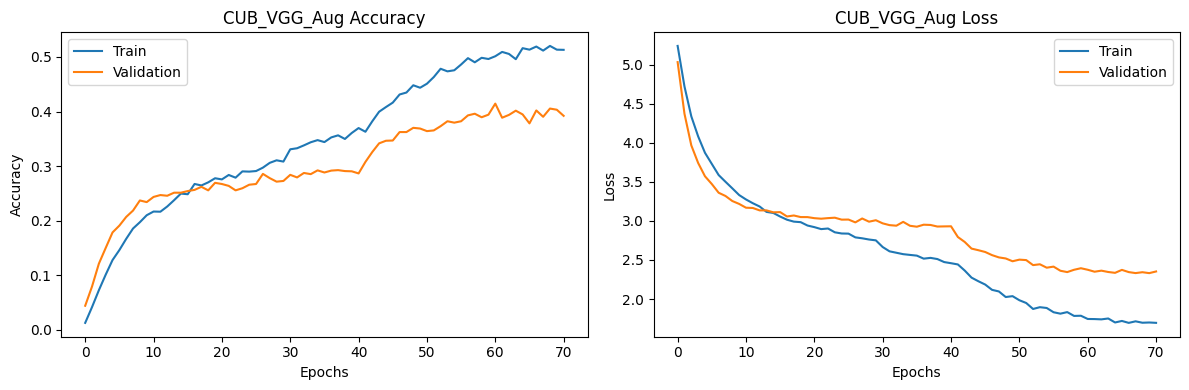

73/73 ━━━━━━━━━━━━━━━━━━━━ 29s 381ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.42      0.42      0.42        12
              002.Laysan_Albatross       0.45      0.42      0.43        12
               003.Sooty_Albatross       0.31      0.45      0.37        11
             004.Groove_billed_Ani       0.19      0.25      0.21        12
                005.Crested_Auklet       0.50      0.50      0.50         8
                  006.Least_Auklet       0.62      0.62      0.62         8
               007.Parakeet_Auklet       0.56      0.50      0.53        10
             008.Rhinoceros_Auklet       0.29      0.22      0.25         9
              009.Brewer_Blackbird       0.67      0.18      0.29        11
          010.Red_winged_Blackbird       0.44      0.58      0.50        12
               011.Rusty_Blackbird       0.17      0.17      0.17        12
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


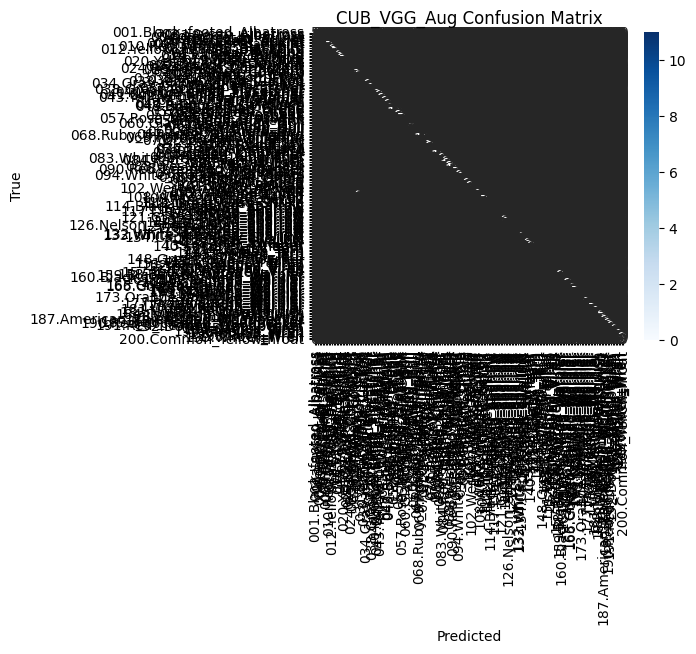

Resultados guardados para: CUB_VGG_Aug

Dataset: CUB, Modelo: RESNET, Augmentation: False
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0086 - loss: 5.3698

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.0086 - loss: 5.3696 - val_accuracy: 0.0155 - val_loss: 5.2782 - learning_rate: 0.0010
Epoch 2/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0143 - loss: 5.2343 - val_accuracy: 0.0232 - val_loss: 5.1169 - learning_rate: 0.0010
Epoch 3/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0202 - loss: 5.0967 - val_accuracy: 0.0323 - val_loss: 4.9558 - learning_rate: 0.0010
Epoch 4/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0246 - loss: 4.9623 - val_accuracy: 0.0456 - val_loss: 4.8380 - learning_rate: 0.0010
Epoch 5/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.0337 - loss: 4.8422 - val_accuracy: 0.0413 - val_loss: 4.7920 - learning_rate: 0.0010
Epoch 6/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0421 - loss: 4.7872 - val_accuracy: 0.0474 - val_loss: 4.7193 - learning_rate: 0.0010
Epoch 7/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.0460 - loss:

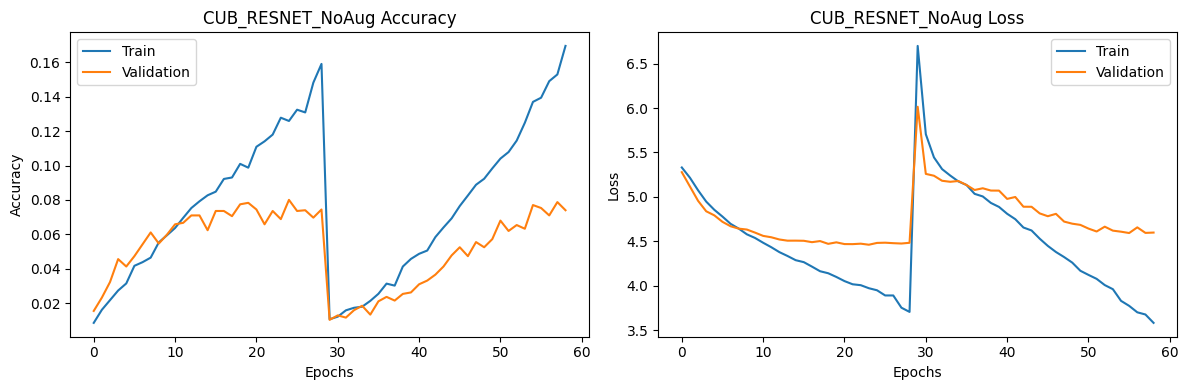

73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.17      0.08      0.11        12
              002.Laysan_Albatross       0.00      0.00      0.00        12
               003.Sooty_Albatross       0.10      0.09      0.10        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       0.14      0.25      0.18         8
               007.Parakeet_Auklet       0.15      0.30      0.20        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.25      0.17      0.20        12
               011.Rusty_Blackbird       0.25      0.08      0.12        12
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


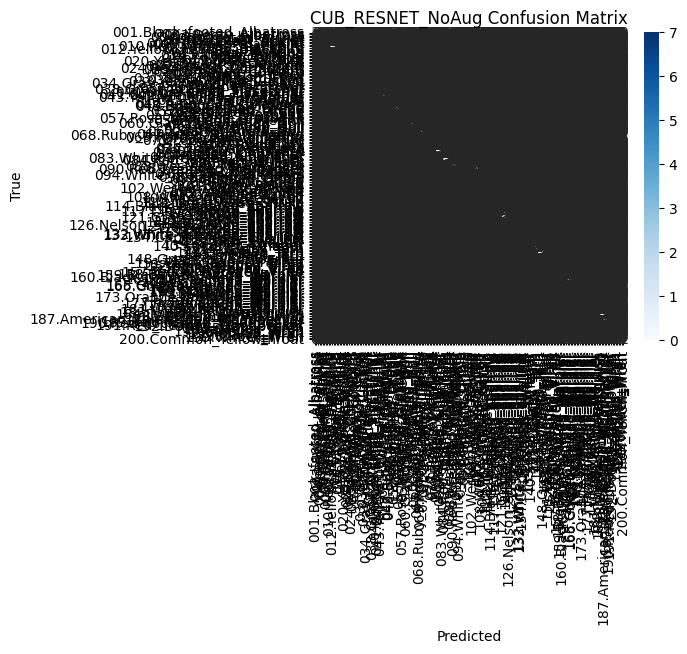

Resultados guardados para: CUB_RESNET_NoAug

Dataset: CUB, Modelo: RESNET, Augmentation: True
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.0069 - loss: 5.3647

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 162s 511ms/step - accuracy: 0.0069 - loss: 5.3646 - val_accuracy: 0.0082 - val_loss: 5.2812 - learning_rate: 0.0010
Epoch 2/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 472ms/step - accuracy: 0.0155 - loss: 5.2172 - val_accuracy: 0.0211 - val_loss: 5.1356 - learning_rate: 0.0010
Epoch 3/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 477ms/step - accuracy: 0.0218 - loss: 5.1030 - val_accuracy: 0.0250 - val_loss: 4.9707 - learning_rate: 0.0010
Epoch 4/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 473ms/step - accuracy: 0.0239 - loss: 5.0022 - val_accuracy: 0.0331 - val_loss: 4.8662 - learning_rate: 0.0010
Epoch 5/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 472ms/step - accuracy: 0.0271 - loss: 4.9171 - val_accuracy: 0.0357 - val_loss: 4.7928 - learning_rate: 0.0010
Epoch 6/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - accuracy: 0.0360 - loss: 4.8468 - val_accuracy: 0.0452 - val_loss: 4.7236 - learning_rate: 0.0010
Epoch 7/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 472ms/step - accuracy: 0.0363 

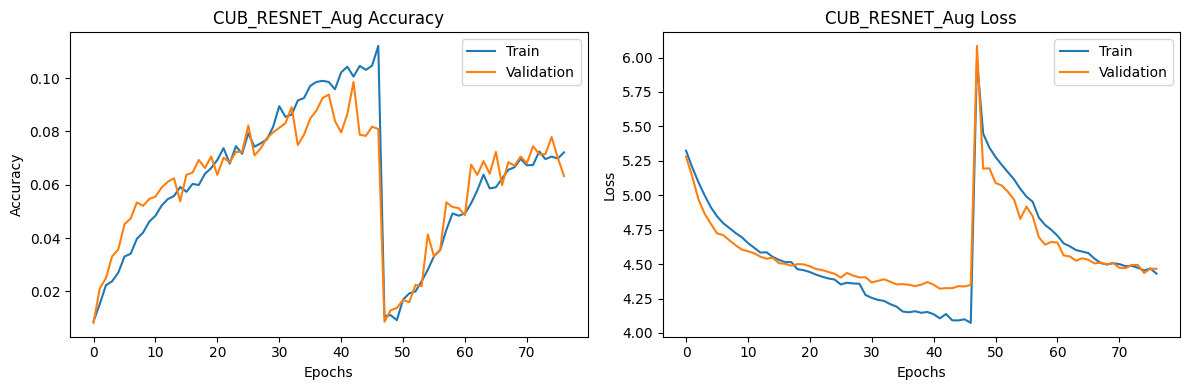

73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 420ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 375ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.00      0.00      0.00        12
              002.Laysan_Albatross       0.08      0.08      0.08        12
               003.Sooty_Albatross       0.33      0.09      0.14        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       0.17      0.25      0.20         8
               007.Parakeet_Auklet       0.22      0.20      0.21        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.13      0.17      0.15        12
               011.Rusty_Blackbird       0.00      0.00      0.00        12
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


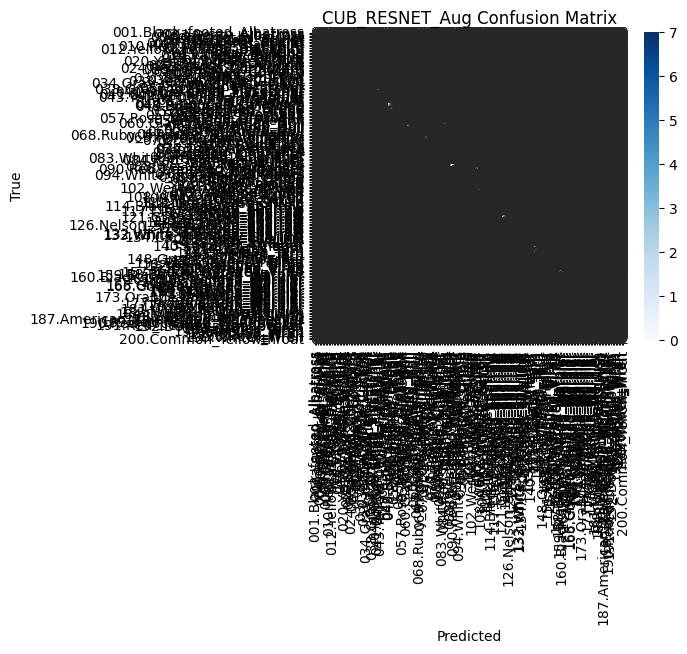

Resultados guardados para: CUB_RESNET_Aug


In [ ]:
experiments = [
    {
        'dataset': '/content/CUB_200_2011/images',  
        'class_mode': 'categorical',
        'class_names': None, 
        'num_classes': 200,
        'label': 'CUB'
    }
]

for exp in experiments:
    for model_name in ['vgg', 'resnet']:
        for aug in [False, True]:
            # Fase 1 — training
            print("\n==============================")
            print(f"Dataset: {exp['label']}, Modelo: {model_name.upper()}, Augmentation: {aug}")
            print("==============================")

            train_gen, val_gen = prepare_generators(exp['dataset'], augment=aug, class_mode=exp['class_mode'])

            if exp['class_names'] is None:
                class_names = list(train_gen.class_indices.keys())
            else:
                class_names = exp['class_names']

            model = create_model(model_name=model_name, num_classes=exp['num_classes'])

            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
                ModelCheckpoint(f'{exp["label"]}_{model_name.upper()}_{"Aug" if aug else "NoAug"}_best.keras',
                                monitor='val_loss', save_best_only=True)
            ]

            history = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=80,
                callbacks=callbacks
            )

            # Fase 2 — fine-tuning
            print("\n=== Starting Fine-Tuning Phase ===")
            # Selective unfreezing
            if model_name == 'vgg':
                set_trainable = False
                for layer in model.layers:
                    if layer.name == 'block5_conv1':
                        set_trainable = True
                    layer.trainable = set_trainable
            elif model_name == 'resnet':
                for layer in model.layers[-30:]:
                    layer.trainable = True

            model.compile(
                optimizer=Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            train_gen.reset()
            val_gen.reset()

            callbacks_finetune = [
                EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
                ModelCheckpoint(f'{exp["label"]}_{model_name.upper()}_{"Aug" if aug else "NoAug"}_fine_tuned.keras',
                                monitor='val_loss', save_best_only=True)
            ]


            history_fine = model.fit(
                train_gen,
                validation_data=val_gen,
                initial_epoch=history.epoch[-1] + 1,
                epochs=history.epoch[-1] + 31,
                callbacks=callbacks_finetune
            )

            # Unify metrics from both training phases
            if history_fine.history:
              for key in history.history:
                  if key in history_fine.history and isinstance(history.history[key], list):
                      history.history[key] += history_fine.history[key]



            title = f"{exp['label']}_{model_name.upper()}_{'Aug' if aug else 'NoAug'}"
            plot_metrics(history, title_prefix=title)

            val_gen.reset()
            y_pred = model.predict(val_gen)
            y_true = val_gen.classes

            y_pred_labels = np.argmax(y_pred, axis=1)
            y_pred_proba = None  # ROC solo para binario

            evaluate_model(model, val_gen, class_names=class_names, title_prefix=title)
            save_results(model, history, title_prefix=title, y_true=y_true, y_pred_labels=y_pred_labels, y_pred_proba=y_pred_proba, class_names=class_names)

# Save results

In [13]:
!cp -r resultados_modelos /content/drive/MyDrive/TFG_resultados_mejoras/

!zip -r resultados_modelos.zip resultados_modelos

from google.colab import files
files.download("resultados_modelos.zip")

  adding: resultados_modelos/ (stored 0%)
  adding: resultados_modelos/CUB_RESNET_Aug_metrics.png (deflated 4%)
  adding: resultados_modelos/CUB_VGG_Aug_model.keras (deflated 7%)
  adding: resultados_modelos/CUB_RESNET_Aug_model.keras (deflated 8%)
  adding: resultados_modelos/CUB_VGG_Aug_history.txt (deflated 61%)
  adding: resultados_modelos/CUB_VGG_Aug_confusion_matrix.png (deflated 8%)
  adding: resultados_modelos/CUB_VGG_Aug_metrics.png (deflated 5%)
  adding: resultados_modelos/CUB_RESNET_NoAug_metrics.png (deflated 5%)
  adding: resultados_modelos/CUB_RESNET_NoAug_history.txt (deflated 63%)
  adding: resultados_modelos/CUB_RESNET_NoAug_confusion_matrix.png (deflated 9%)
  adding: resultados_modelos/CUB_VGG_NoAug_metrics.png (deflated 6%)
  adding: resultados_modelos/CUB_VGG_NoAug_confusion_matrix.png (deflated 8%)
  adding: resultados_modelos/CUB_RESNET_Aug_confusion_matrix.png (deflated 8%)
  adding: resultados_modelos/CUB_RESNET_Aug_history.txt (deflated 63%)
  adding: resulta

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>